Packages:

In [27]:
import glob
import os
import warnings
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [28]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())

In [29]:
# Specify the file names and DataFrame variable names
file_names = ["train_df_2.csv", "test_df_2.csv"]

# Load the data from the CSV files
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]

# Unpack the dataframes into separate variables
train_df, test_df = dataframes

print("DataFrames have been loaded successfully.")



DataFrames have been loaded successfully.


In [30]:
train_df.dtypes

study_id           int64
severity         float64
condition          int64
level             object
series_id        float64
x                float64
y                float64
image_path        object
missing_image       bool
dtype: object

training model setting

In [32]:
# define transformation and class

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
# %pip install torch torchvision
import torchvision.models as models
from torchvision import transforms
import pydicom
# %pip install opencv-python
import cv2
import pandas as pd


# Define the transform with augmentation: I already tranformed i tbfore 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(10),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)



training model resnet50 sotp if validation and train go apart

In [33]:
train_data = train_df

# train_data = train_df.sample(n=15, random_state=RSEED)

Epoch [1/30], Train Cross Entropy Loss: 1.0470, Validation Cross Entropy Loss: 0.9696
Epoch [2/30], Train Cross Entropy Loss: 0.9167, Validation Cross Entropy Loss: 1.0014
Epoch [3/30], Train Cross Entropy Loss: 0.7389, Validation Cross Entropy Loss: 0.7577
Epoch [4/30], Train Cross Entropy Loss: 0.5378, Validation Cross Entropy Loss: 0.6703
Epoch [5/30], Train Cross Entropy Loss: 0.3415, Validation Cross Entropy Loss: 0.6011
Early stopping at epoch 6 due to validation loss diverging.
Training complete!


2024/11/06 08:58:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


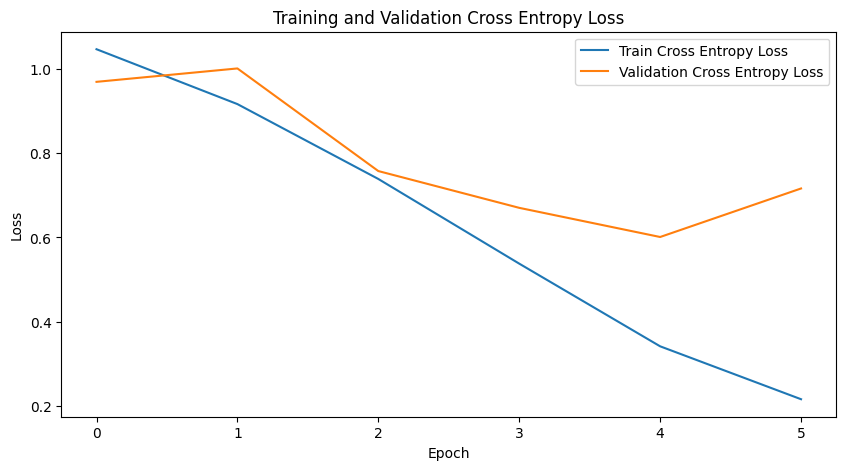

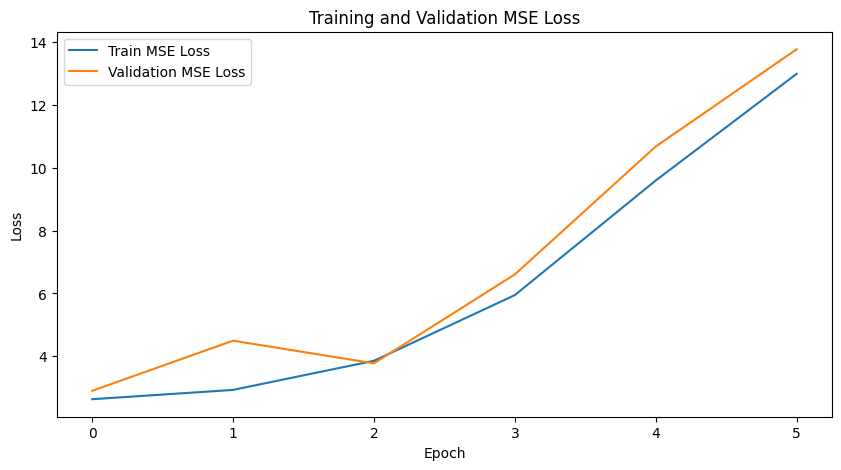

In [34]:
# %pip install mlflow
# %pip install tensorflow
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
# %pip install keras
# %pip install tensorflow
# from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
import numpy as np  # Import numpy for setting the random seed
import random
#from tensorflow.keras.callbacks import ModelCheckpoint

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)  # Set seed for numpy
random.seed(seed)  # Set seed for random module

# Create a new experiment
experiment_name = "Resnet50_MRI_Classification_2"
mlflow.set_experiment(experiment_name)

# Create the dataset
dataset = MRIDataset(data=train_data, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load ResNet-50 and set up for classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = train_df['severity'].nunique()

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

# Early stopping parameters
# stop_early = EarlyStopping(monitor='val_loss', patience=6, verbose=1)

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge

# Calculate number of layers in the model
num_layers = len(list(model.children()))

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("model_architecture", "ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("activation_function", "ReLU")
    mlflow.log_param("pretrained_weights", "IMAGENET1K_V1")

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Example target
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        model.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Check for early stopping
        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(model, "model")

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")


In [ ]:
sss

s

In [35]:
# renet50
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for setting the random seed

# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)  # Set seed for numpy
import random
random.seed(seed)  # Set seed for random module

# Create a new experiment
experiment_name = "Resnet50_MRI_Classification_2"
# Uncomment the line below to create a new experiment only if it doesn't already exist
# mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Create the dataset
dataset = MRIDataset(data=train_data, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load ResNet-50 and set up for classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = train_df['severity'].nunique()

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Define loss functions and optimizer
criterion_cel = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []
train_losses_mse = []
val_losses_mse = []

# Early stopping parameters
stop_threshold = 0.2  # Threshold for validation loss to diverge from training loss
diverge_count = 0
max_diverge_count = 3  # Number of epochs validation loss is allowed to diverge

# Calculate number of layers in the model
num_layers = len(list(model.children()))

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 4)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("stop_threshold", stop_threshold)
    mlflow.log_param("model_architecture", "ResNet-50")
    mlflow.log_param("input_size", "224x224")
    mlflow.log_param("num_layers", num_layers)  # Log number of layers
    mlflow.log_param("activation_function", "ReLU")  # Log activation function
    mlflow.log_param("pretrained_weights", "IMAGENET1K_V1")

    # Training and validation loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss_cel_train = 0.0
        running_loss_mse_train = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()

            # MSE Loss (if applicable)
            mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Example target
            loss_mse = criterion_mse(outputs, mse_target)
            running_loss_mse_train += loss_mse.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average losses
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)
        epoch_loss_mse_train = running_loss_mse_train / len(train_loader)
        train_losses_mse.append(epoch_loss_mse_train)

        # Log training losses to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)
        mlflow.log_metric("train_loss_mse", epoch_loss_mse_train, step=epoch)

        # Validation phase
        model.eval()
        running_loss_cel_val = 0.0
        running_loss_mse_val = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()
                
                # MSE Loss (if applicable)
                mse_target = labels.float().unsqueeze(1).expand_as(outputs)  # Ensure mse_target matches outputs shape
                loss_mse = criterion_mse(outputs, mse_target)
                running_loss_mse_val += loss_mse.item()

        # Calculate validation losses
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)
        epoch_loss_mse_val = running_loss_mse_val / len(val_loader)
        val_losses_mse.append(epoch_loss_mse_val)

        # Log validation losses to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)
        mlflow.log_metric("val_loss_mse", epoch_loss_mse_val, step=epoch)

        # Early stopping check
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch+1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset count if validation loss improves

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

    print("Training complete!")

    # Log the model
    mlflow.pytorch.log_model(model, "model")

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")

    # Plot MSE Loss if applicable
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_mse, label='Train MSE Loss')
    plt.plot(val_losses_mse, label='Validation MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation MSE Loss')
    plt.legend()
    plt.savefig("mse_loss.png")
    mlflow.log_artifact("mse_loss.png")


KeyboardInterrupt: 

In [ ]:
s

Restore parameters and metrtics from mlflow

I should take prdicted probabilities and not predicted classes: output scores (logits) are converted into probabilities using the softmax function

In [35]:
import mlflow
import mlflow.pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Set the experiment name
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Move model to appropriate device
model.eval()  # Set the model to evaluation mode

# Prepare data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']
        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)
        return image_tensor, torch.tensor(label).long()

    def __len__(self):
        return len(self.data)

predicting probabilities for test data

In [ ]:
train_data = random_samples_test_check

test_dataset = MRIDataset(data=train_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inference loop with probability extraction
results = []
probabilities_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Calculate class probabilities
        _, predicted_classes = torch.max(outputs, 1)
        
        # Append predictions and probabilities
        results.append(predicted_classes.item())
        probabilities_list.append(probabilities.cpu().numpy())



In [ ]:
# Print predicted classes and their probabilities
for i, (pred, probs) in enumerate(zip(results, probabilities_list)):
    print(f"Test image {i}: Predicted class {pred}, Probabilities: {probs}")

# Additional code to plot the confusion matrix can stay as-is:
true_labels = []
predicted_labels = []

for images, labels in test_loader:
    images = images.to(device)
    true_labels.extend(labels.numpy())

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"Actual {i}" for i in range(len(conf_matrix))], 
    columns=[f"Predicted {i}" for i in range(len(conf_matrix[0]))]
)

# Print the confusion matrix DataFrame
print(conf_matrix_df)

# Optionally, display it using a more formatted view (e.g., in Jupyter Notebook)
conf_matrix_df.style.background_gradient(cmap='Blues')


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, and accuracy using mean_probabilities_df
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


In [ ]:
ssss

These ones are predicted classes: 

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd
import numpy as np
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the experiment name (optional, helps in identifying runs)
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID

# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)

# Now you can use the model for inference or evaluation
model.eval()  # Set the model to evaluation mode

# Define the transform with augmentation: I already transformed it before 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(10),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the Dataset class
class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)

# Sample the test DataFrame
test_df = df_end.sample(n=300, random_state=RSEED)  # Replace RSEED with your seed

# Create the test dataset and loader
test_dataset = MRIDataset(data=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Collect true labels and predicted labels
for images, labels in test_loader:
    images = images.to(device)

    # Store the true labels
    true_labels.extend(labels.numpy())  # Convert to numpy and extend the list

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())  # Move to CPU and convert to list

# Convert to numpy arrays for confusion matrix
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({
    'True Severity': true_labels,
    'Predicted Severity': predicted_labels
})

# Display the DataFrame
print(results_df.head())  # Show the first few rows of the DataFrame

# Optionally, save the DataFrame to a CSV file for further analysis
results_df.to_csv('predictions_results.csv', index=False)

# Check the unique values in the true and predicted labels
print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract true labels and predicted labels from results_df
true_labels = results_df['True Severity']
predicted_labels = results_df['Predicted Severity']

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix from results_df")
plt.show()

In [ ]:
test_df =train_df.sample(n=300, random_state=RSEED)

import mlflow
import mlflow.pytorch

# Set the experiment name (optional, helps in identifying runs)
experiment_name = "Resnet50_MRI_Classification"
mlflow.set_experiment(experiment_name)

# Specify the run ID of the logged model
run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID

# Create the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
model = mlflow.pytorch.load_model(model_uri)

# Now you can use the model for inference or evaluation
model.eval()  # Set the model to evaluation mode
# Get all runs for the experiment
runs = mlflow.search_runs(experiment_names=[experiment_name])

print(runs.filter(like='params.').to_string(index=False))
# Display all metrics
metrics_columns = [col for col in runs.columns if col.startswith('metrics.')]
print(runs[metrics_columns].to_string(index=False))

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
# Define the transform with augmentation: I already tranformed i tbfore 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(10),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)

# Replace 'df_test' with your actual DataFrame containing test data
test_dataset = MRIDataset(data=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Adjust batch size as needed
test_dataset
test_loader

run_id = "f390913c59d642329c86d0f52b943062"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()  # Set the model to evaluation mode

import torch

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
results = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor(labels)  # Convert labels to tensor
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        
        # Append predictions with corresponding image paths or indices
        results.append(predicted_classes.item())

# Print or save predictions as needed
for i, pred in enumerate(results):
    print(f"Test image {i}: Predicted class {pred}")



# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Collect true labels and predicted labels
for images, labels in test_loader:
    images = images.to(device)

    # Store the true labels
    true_labels.extend(labels.numpy())  # Convert to numpy and extend the list

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())  # Move to CPU and convert to list

# Convert to numpy arrays for confusion matrix
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Check the unique values in the true and predicted labels
print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))


In [ ]:
# Generate the confusion matrix, explicitly specifying labels
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

# Display the confusion matrix with fixed display labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

 
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.4f}")